In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from skimage.filters import gaussian
from skimage.registration import phase_cross_correlation
from skimage.transform import EuclideanTransform, warp
from scipy.stats import norm 

#### wave speed:
- all for pAAA, single, triple reporter. Compare RFP wave speed in pAAA vs triple reporter
- time traveling according to size (radius, area)
- starting/ending time of the wave for the same pads
- same above but comparing repressor sequestration (IPTG, ATC)

In [2]:
exp_sum = pd.read_excel('../Exps_summary.xlsx')
exp_sum['formatted_dates'] = exp_sum['Date'].dt.strftime('%Y_%m_%d')
positions = pd.read_excel('../Positions.xlsx')
exp_sum

,Date,Machine,Strain,DNA,Chemical,Dilution,formatted_dates
0,2023-11-15,Ti scope,MC4100 & DHL708,pLPT20&pLPT41,-,10^(-5),2023_11_15
1,2023-11-15,Tweez scope,MC4100 & DHL708,pLPT20&pLPT41,-,10^(-6),2023_11_15
2,2023-11-17,Ti scope,DHL708,pLPT119&pLPT41,-,10^(-5),2023_11_17
3,2023-11-17,Tweez scope,MC4100 & DHL708,pLPT119&pLPT41,-,10^(-6),2023_11_17
4,2023-11-28,Ti scope,MC4100 & MG1655,pAAA,-,10^(-6),2023_11_28
5,2023-11-28,Tweez scope,MG1655,pAAA,-,10^(-5),2023_11_28
6,2023-11-30,Ti scope,MC4100,pAAA,-,10^(-6),2023_11_30
7,2023-11-30,Tweez scope,MC4100,pAAA,-,10^(-5),2023_11_30
8,2023-12-04,Ti scope,MC4100,pLPT107&pLPT41,IPTG,10^(-6),2023_12_04
9,2023-12-04,Tweez scope,MC4100,pLPT107&pLPT41,IPTG,10^(-5),2023_12_04


#### Bar plots

In order to compute statistics of the start and arrival time, we have to remove the data pAAA from Ti (wave does not arrive), and 2023_12_08 Tweez (growth delayed because of aTc)

In [7]:
# Load the data
df = pd.read_excel('../data_processed.xlsx')

# Filter out the unwanted combinations
filtered_df = df[
    ~(
        ((df['Machine'] == 'Ti scope') & (df['DNA'] == 'pAAA')) |
        ((df['Date'] == '2023-12-08'))
    )
]

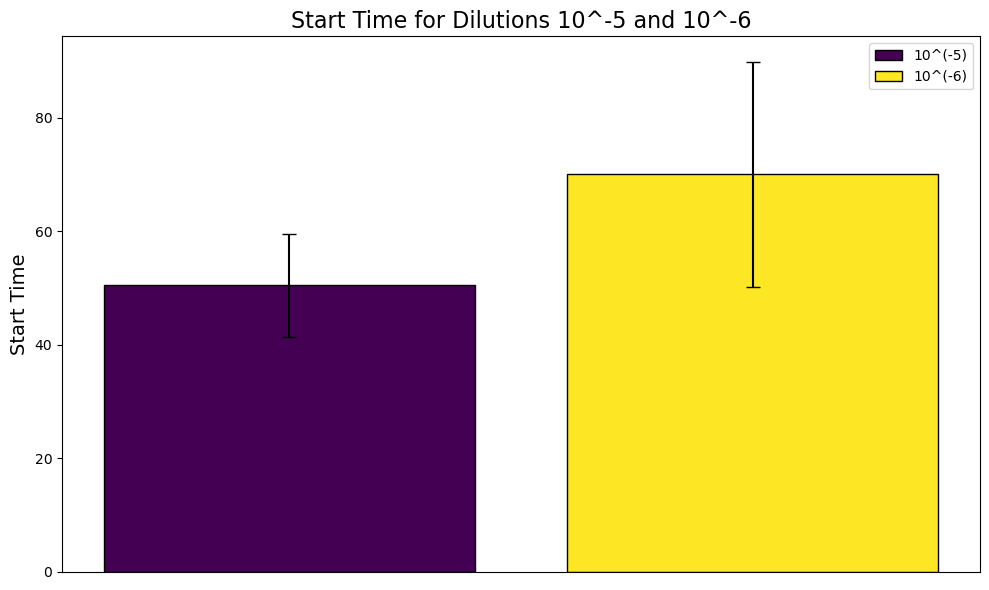

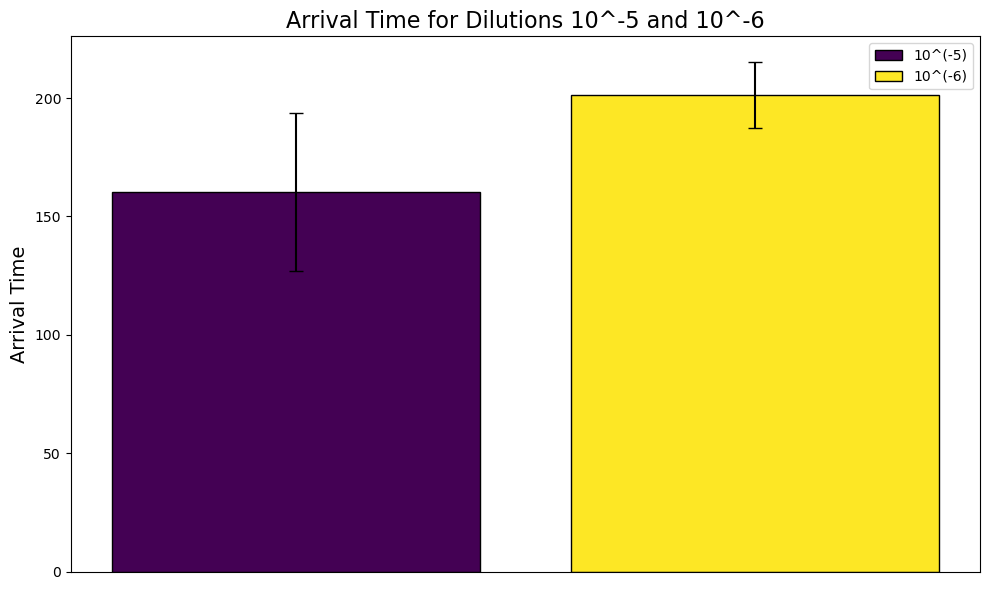

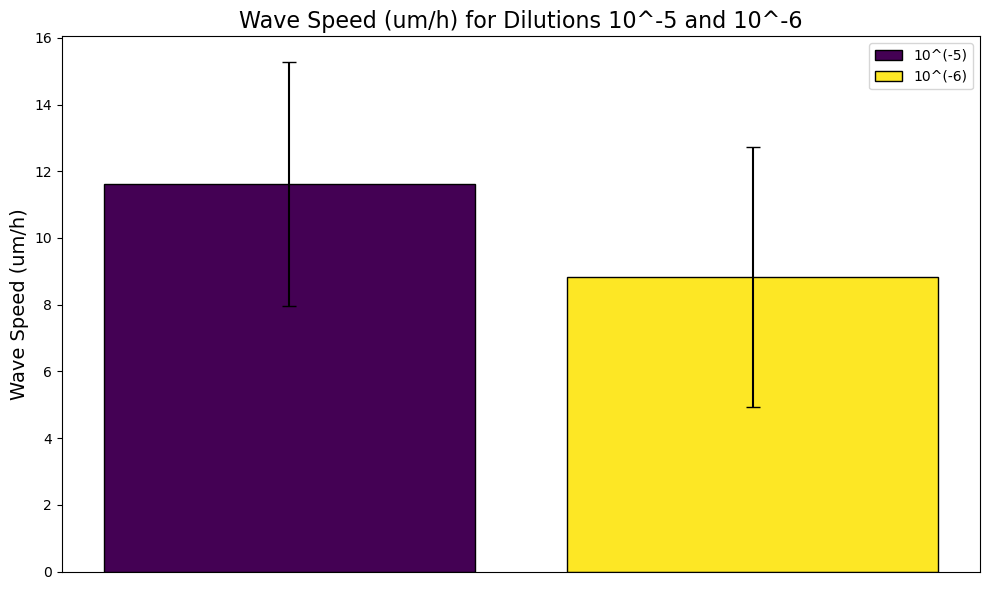

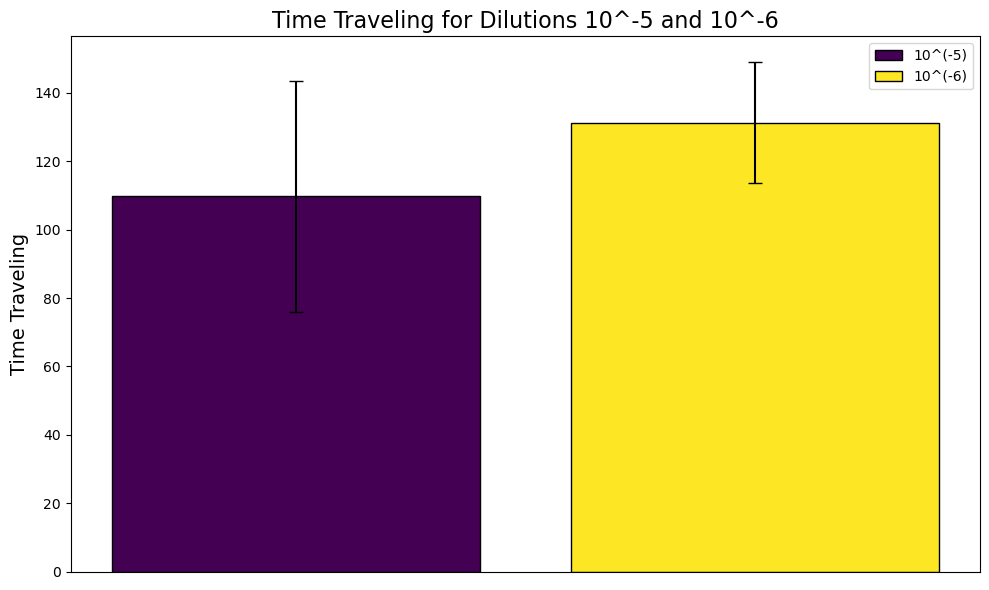

In [5]:
# Load the data
#df = pd.read_excel('../data_processed.xlsx')
df = filtered_df
#df = df[df.r0_um > 0.1]
df['time_traveling'] = df['time_wave_arrival'] - df['time_wave_start']

# Group the data by Dilution and calculate the statistics
grouped_df = df.groupby(['Dilution']).agg({
    'time_wave_start': ['mean', 'std'],
    'time_wave_arrival': ['mean', 'std'],
    'wave_speed_av': ['mean', 'std'],
    'time_traveling': ['mean', 'std'],
    'r0_um': ['mean', 'std'],
    'rad_max_um': ['mean', 'std'],
    'area_max_um': ['mean', 'std'],
    'Dilution': 'first',  # Include Dilution to keep it in the DataFrame
}).reset_index()

# Flatten the multi-level column index for easier access
grouped_df.columns = [
    col[0] if col[1] == '' else f'{col[0]}_{col[1]}'.strip('_')
    for col in grouped_df.columns
]

# Select only the dilutions you're interested in
selected_dilutions = grouped_df[grouped_df['Dilution'].isin(['10^(-5)', '10^(-6)'])]

# Generate colors for the two dilutions using the viridis color map
area_colors = plt.cm.viridis(np.linspace(0, 1, 2))

# Plotting function for all statistics
def plot_all_statistics():
    for stat_name, ylabel in [
        ('time_wave_start', 'Start Time'),
        ('time_wave_arrival', 'Arrival Time'),
        ('wave_speed_av', 'Wave Speed (um/h)'),
        ('time_traveling', 'Time Traveling'),
        #('r0_um', 'R0 (um)'),
        #('rad_max_um', 'Max Radius (um)'),
        #('area_max_um', 'Max Area (um^2)')
    ]:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot the data with specific colors for each dilution
        for pos, (index, row) in enumerate(selected_dilutions.iterrows()):
            ax.bar(pos, row[f'{stat_name}_mean'], yerr=row[f'{stat_name}_std'], capsize=5,
                   color=area_colors[pos], label=row['Dilution'], edgecolor='black')
        
        # Remove x-axis labels and ticks
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel('')  # Optionally clear the xlabel if it was set elsewhere
        
        # Add y-axis label and title
        ax.set_ylabel(ylabel, fontsize=14)
        ax.set_title(f'{ylabel} for Dilutions 10^-5 and 10^-6', fontsize=16)
        
        # Add legend
        ax.legend()
        
        # Tight layout
        plt.tight_layout()
        plt.show()

# Plot all the statistics
plot_all_statistics()


#### Histograms

In [6]:
# Load the data
df = pd.read_excel('../data_processed.xlsx')

# Filter out the unwanted combinations
filtered_df = df[
    ~(
        ((df['Machine'] == 'Ti scope') & (df['DNA'] == 'pAAA')) |
        ((df['Date'] == '2023-12-08'))
    )
]

/tmp/ipykernel_4326/987523691.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_traveling'] = df['time_wave_arrival'] - df['time_wave_start']


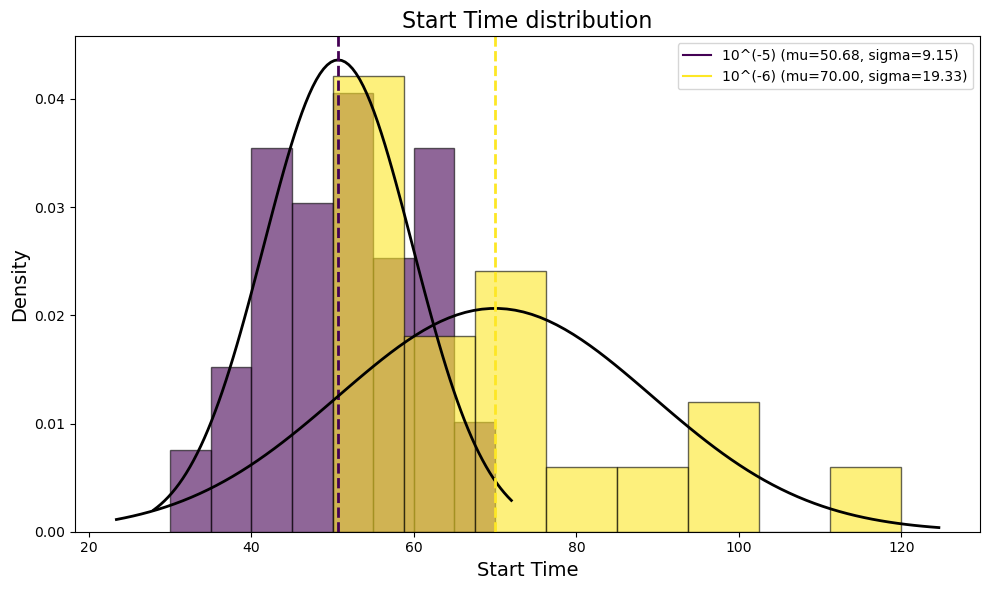

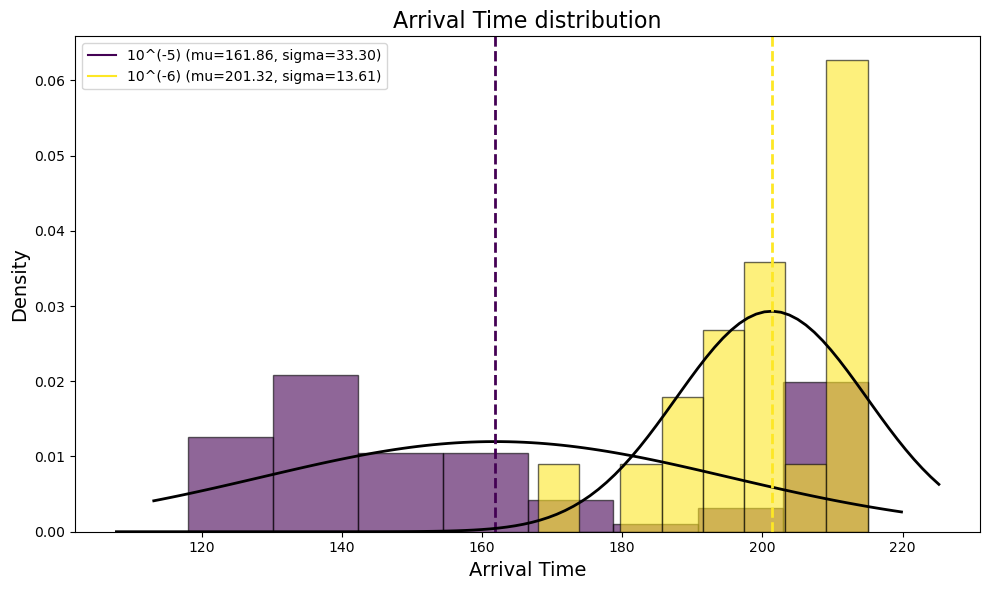

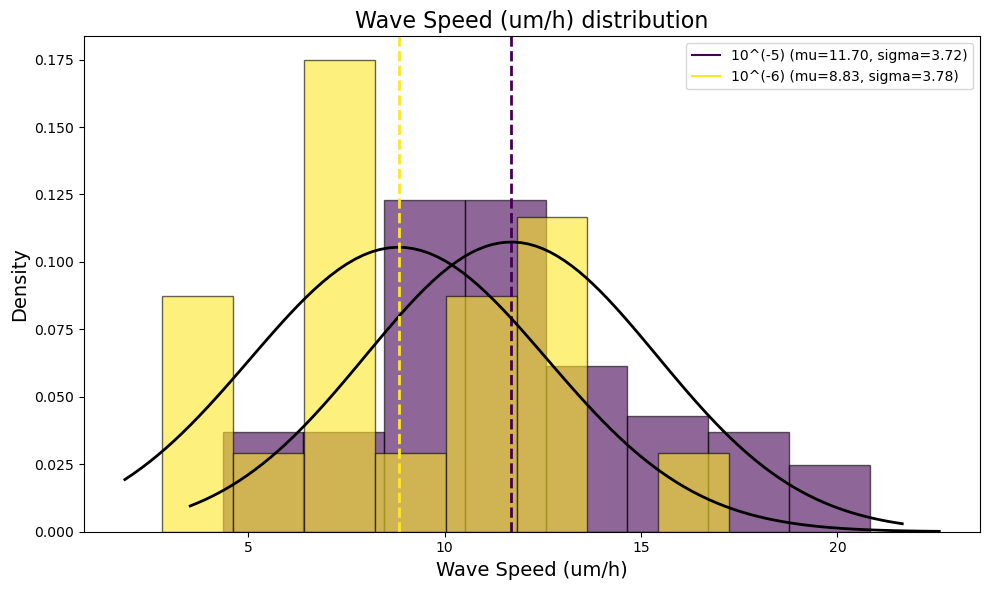

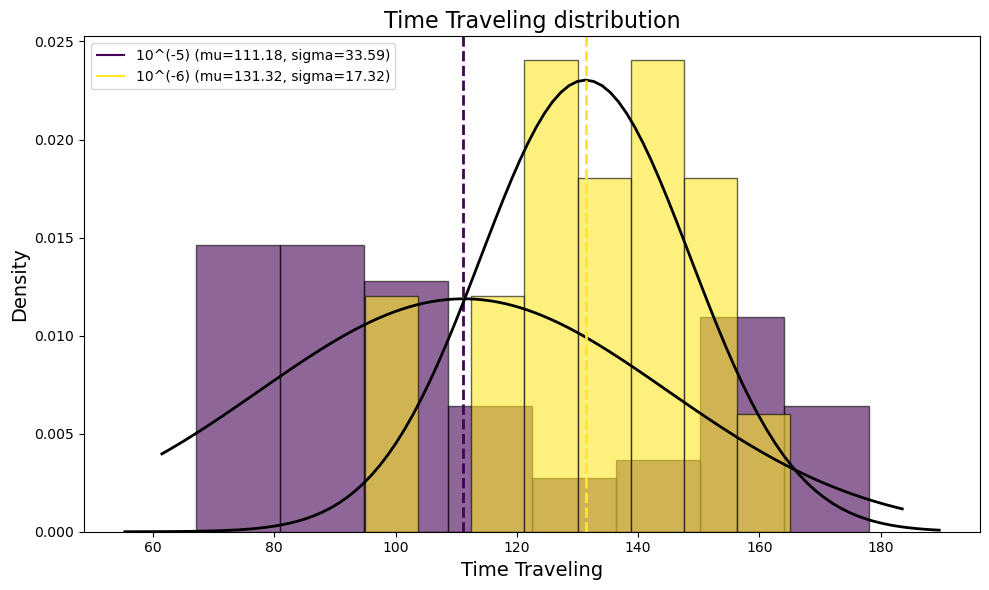

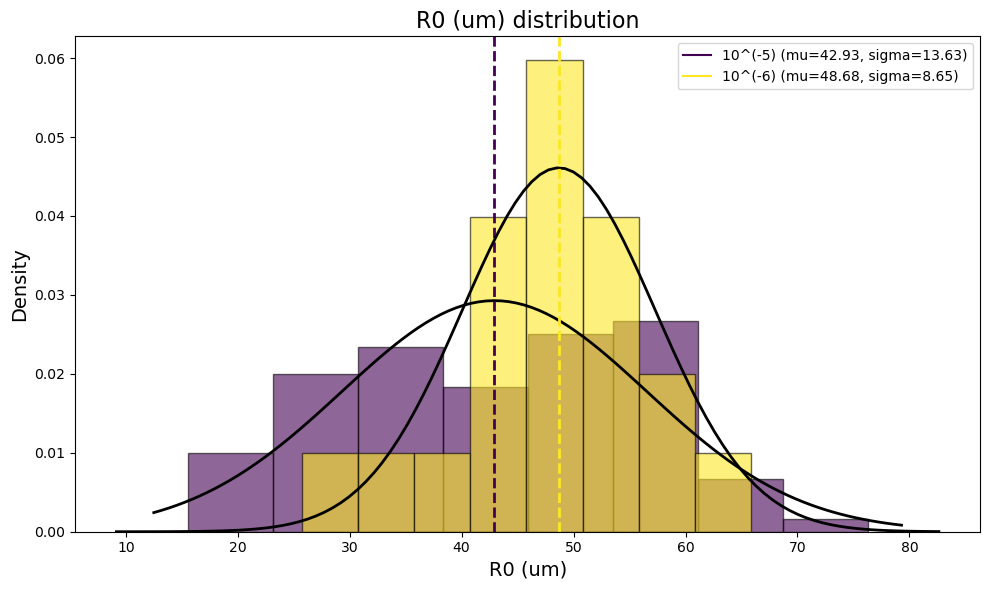

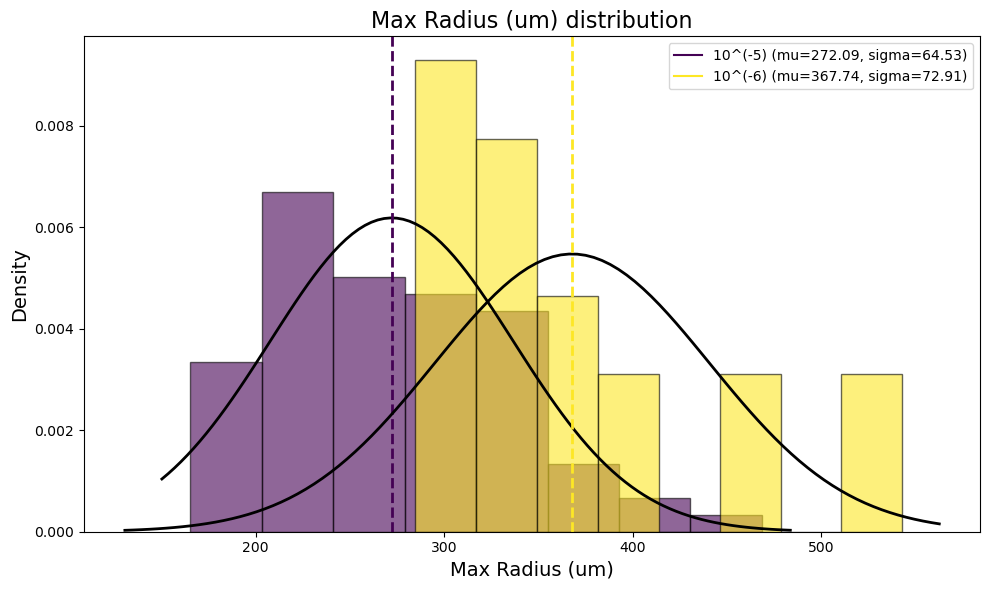

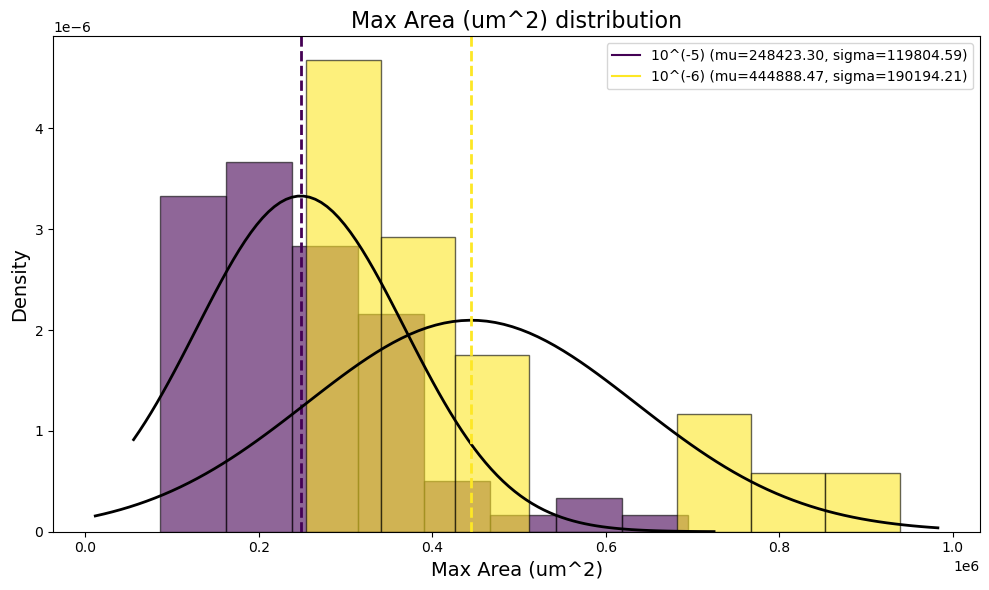

In [22]:
# Load the data
#df = pd.read_excel('../data_processed.xlsx')
df = filtered_df
#df = df[df.r0_um > 0.1]

# Calculate time traveling for each colony
df['time_traveling'] = df['time_wave_arrival'] - df['time_wave_start']

# Group the data by Dilution and calculate the statistics
grouped_df = df.groupby(['Dilution']).agg({
    'time_wave_start': ['mean', 'std'],
    'time_wave_arrival': ['mean', 'std'],
    'wave_speed_av': ['mean', 'std'],
    'time_traveling': ['mean', 'std'],
    'r0_um': ['mean', 'std'],
    'rad_max_um': ['mean', 'std'],
    'area_max_um': ['mean', 'std'],
    'Dilution': 'first',  # Include Dilution to keep it in the DataFrame
}).reset_index()

# Flatten the multi-level column index for easier access
grouped_df.columns = [
    col[0] if col[1] == '' else f'{col[0]}_{col[1]}'.strip('_')
    for col in grouped_df.columns
]

# Select only the dilutions you're interested in
selected_dilutions = grouped_df[grouped_df['Dilution'].isin(['10^(-5)', '10^(-6)'])]

# Generate colors for the two dilutions using the viridis color map
area_colors = plt.cm.viridis(np.linspace(0, 1, 2))

# Function to plot histograms and fit normal distributions
def plot_histograms_with_fits():
    for stat_name, ylabel in [
        ('time_wave_start', 'Start Time'),
        ('time_wave_arrival', 'Arrival Time'),
        ('wave_speed_av', 'Wave Speed (um/h)'),
        ('time_traveling', 'Time Traveling'),
        #('r0_um', 'R0 (um)'),
        #('rad_max_um', 'Max Radius (um)'),
        #('area_max_um', 'Max Area (um^2)')
    ]:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        for pos, (index, row) in enumerate(selected_dilutions.iterrows()):
            # Use real data instead of synthetic data
            data = df[df['Dilution'] == row['Dilution']][stat_name]
            
            # Remove non-finite values (NaN, inf, -inf)
            data = data[np.isfinite(data)]
            
            # Plot histogram
            ax.hist(data, bins=8, density=True, alpha=0.6, color=area_colors[pos], edgecolor='black')
            
            # Fit and plot normal distribution
            if len(data) > 0:  # Ensure there's data to fit
                mu, std = norm.fit(data)
                xmin, xmax = ax.get_xlim()
                x = np.linspace(xmin, xmax, 100)
                p = norm.pdf(x, mu, std)
                ax.plot(x, p, 'k', linewidth=2)
                
                # Add mu and sigma to the label
                label = f"{row['Dilution']} (mu={mu:.2f}, sigma={std:.2f})"
                ax.plot([], [], color=area_colors[pos], label=label)  # Adding a blank plot just to include the label
                
                # Add a vertical dashed line for the mean
                ax.axvline(mu, color=area_colors[pos], linestyle='--', linewidth=2)

        # Add labels and title
        ax.set_xlabel(ylabel, fontsize=14)
        ax.set_ylabel('Density', fontsize=14)
        ax.set_title(f'{ylabel} distribution', fontsize=16)
        
        # Add legend
        ax.legend()
        
        # Tight layout
        plt.tight_layout()
        plt.show()

# Plot all the histograms with normal fits
plot_histograms_with_fits()


#### Bar plots per pad

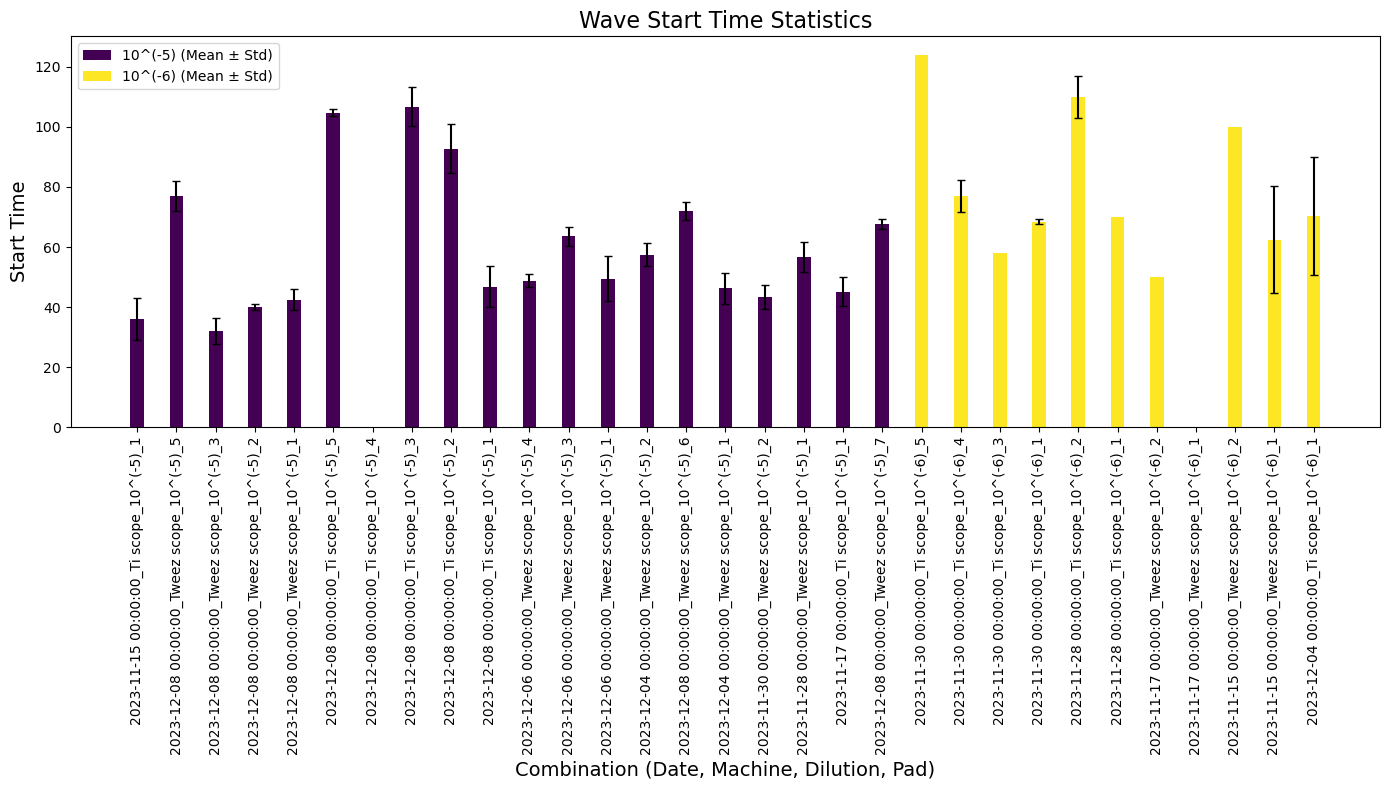

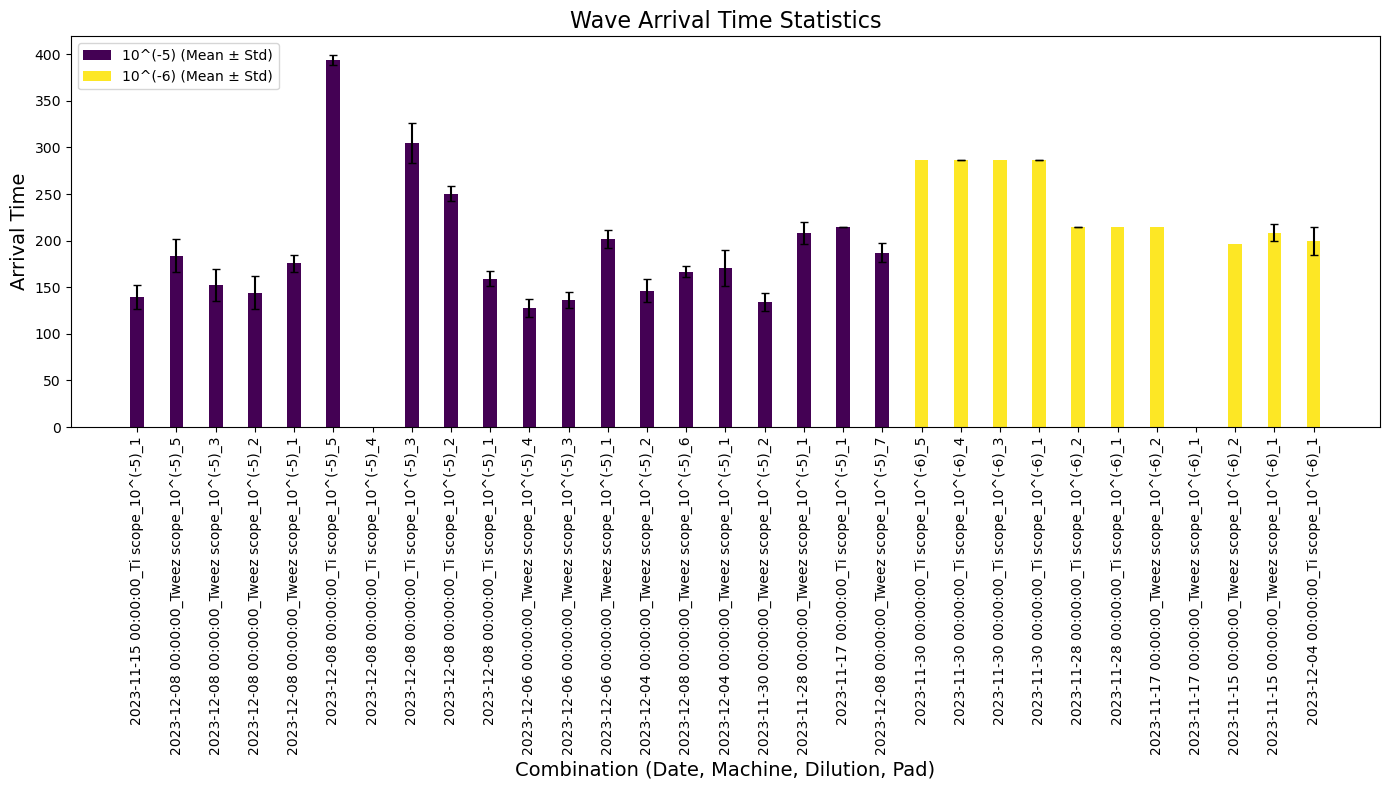

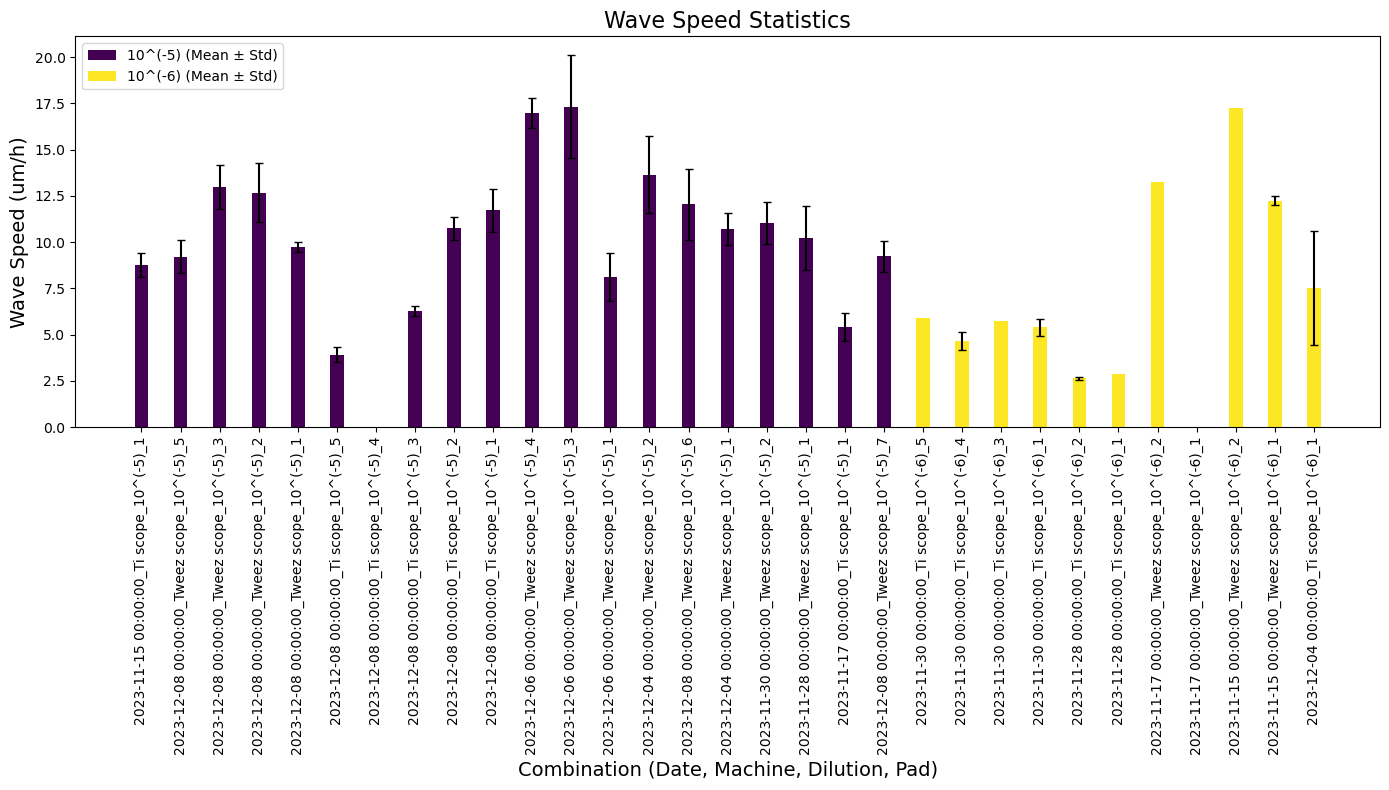

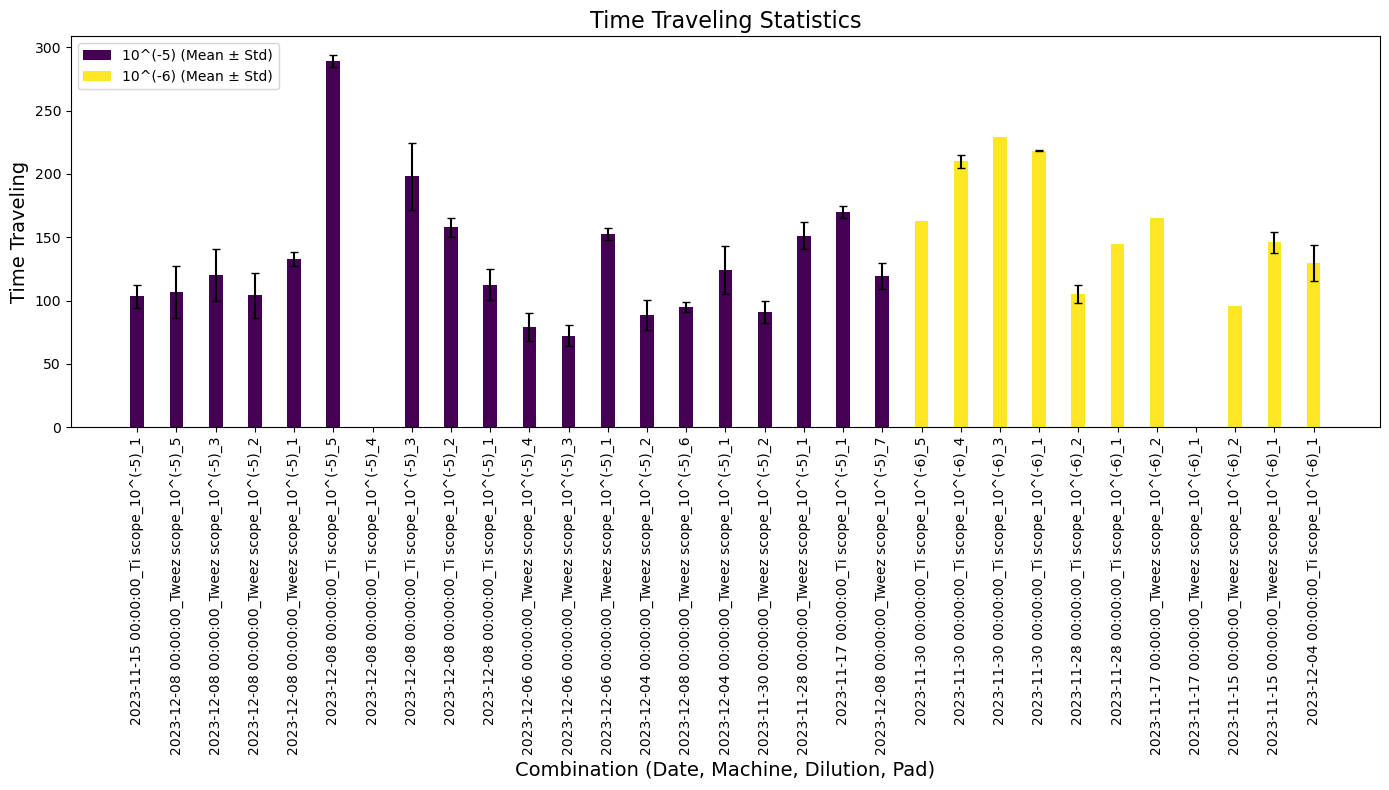

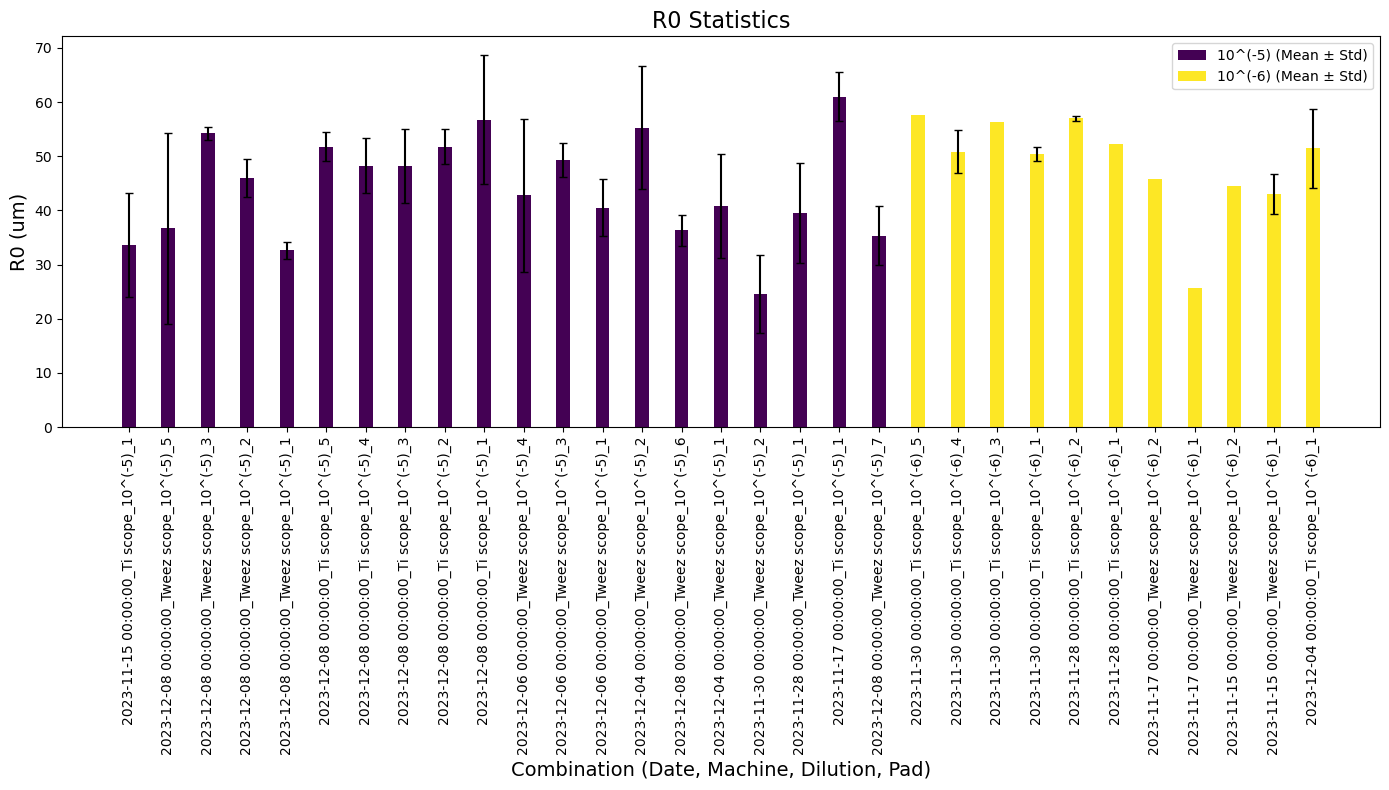

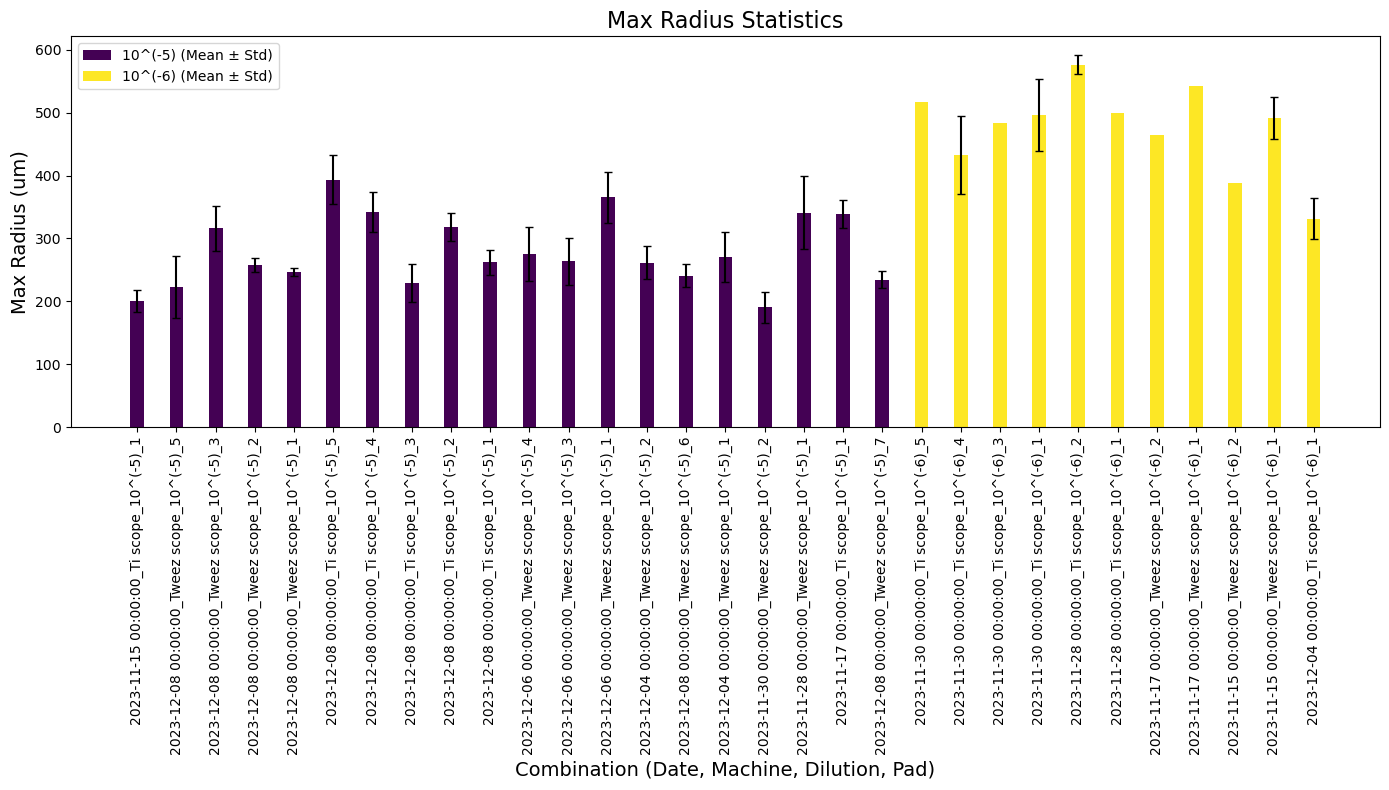

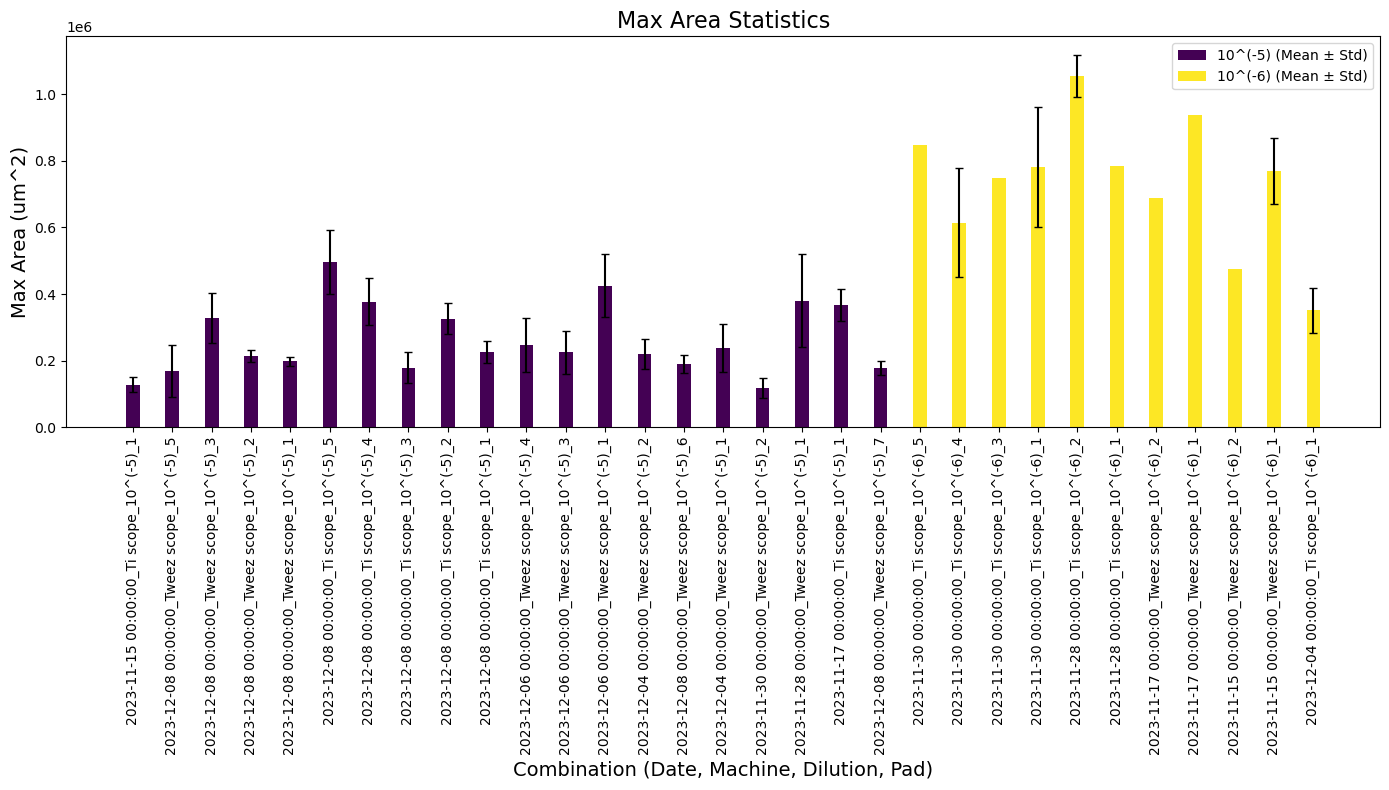

In [143]:
# Load the data
df = pd.read_excel('../data_processed.xlsx')
df = df[df.r0_um > 0.1]

# Calculate time traveling for each colony
df['time_traveling'] = df['time_wave_arrival'] - df['time_wave_start']

# Group the data by Date, Machine, Dilution, and Pad, and calculate the statistics, including the number of colonies per pad
grouped_df = df.groupby(['Date', 'Machine', 'Dilution', 'Pad']).agg({
    'Pad': 'count',  # Count the number of colonies (assuming one row per colony)
    'time_wave_start': ['mean', 'std'],
    'time_wave_arrival': ['mean', 'std'],
    'wave_speed_av': ['mean', 'std'],
    'time_traveling': ['mean', 'std'],
    'r0_um': ['mean', 'std'],
    'rad_max_um': ['mean', 'std'],
    'area_max_um': ['mean', 'std'],
    'Dilution': 'first',  # Include Dilution to keep it in the DataFrame
}).reset_index()

# Rename the 'Pad_count' column to 'num_colonies'
grouped_df.rename(columns={'Pad_count': 'num_colonies'}, inplace=True)

# Flatten the multi-level column index for easier access
grouped_df.columns = [
    col[0] if col[1] == '' else f'{col[0]}_{col[1]}'.strip('_')
    for col in grouped_df.columns
]

# Sort by Dilution to ensure all -5 are on the left and -6 are on the right
grouped_df.sort_values('Dilution', inplace=True)

# Set up the bar width and index for plotting
bar_width = 0.35
index = np.arange(len(grouped_df))

# Generate colors for the two dilutions using the viridis color map
area_colors = plt.cm.viridis(np.linspace(0, 1, 2))

# Function to plot each statistic
def plot_statistic(stat_mean, stat_std, title, ylabel, filename):
    fig, ax = plt.subplots(figsize=(14, 8))
    
    added_labels = { '10^(-5)': False, '10^(-6)': False }  # Track which labels have been added
    
    # Plot bars with error bars, assigning colors based on Dilution
    for i, (pos, row) in enumerate(grouped_df.iterrows()):
        if row['Dilution'] == '10^(-5)':
            color = area_colors[0]
            if not added_labels['10^(-5)']:
                ax.bar(i, row[stat_mean], bar_width, yerr=row[stat_std], capsize=3, color=color, label='10^(-5) (Mean ± Std)')
                added_labels['10^(-5)'] = True  # Mark as added to the legend
            else:
                ax.bar(i, row[stat_mean], bar_width, yerr=row[stat_std], capsize=3, color=color)
        elif row['Dilution'] == '10^(-6)':
            color = area_colors[1]
            if not added_labels['10^(-6)']:
                ax.bar(i, row[stat_mean], bar_width, yerr=row[stat_std], capsize=3, color=color, label='10^(-6) (Mean ± Std)')
                added_labels['10^(-6)'] = True  # Mark as added to the legend
            else:
                ax.bar(i, row[stat_mean], bar_width, yerr=row[stat_std], capsize=3, color=color)
    
    # Add labels and title
    ax.set_xlabel('Combination (Date, Machine, Dilution, Pad)', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(index)
    
    # Create the x-tick labels based on the actual column names
    x_tick_labels = [
        f"{row['Date']}_{row['Machine']}_{row['Dilution_first']}_{row['Pad']}" 
        for _, row in grouped_df.iterrows()
    ]
    ax.set_xticklabels(x_tick_labels, rotation=90, ha='center')
    
    # Add a legend
    ax.legend()
    
    # Adjust layout for better fit
    plt.tight_layout()
    
    # Save and show the plot
    plt.savefig(f'{filename}.png', dpi=300)  # Optionally save the plot
    plt.show()

# List of statistics to plot
stats_to_plot = [
    ('time_wave_start_mean', 'time_wave_start_std', 'Wave Start Time Statistics', 'Start Time', 'wave_start_time_statistics'),
    ('time_wave_arrival_mean', 'time_wave_arrival_std', 'Wave Arrival Time Statistics', 'Arrival Time', 'wave_arrival_time_statistics'),
    ('wave_speed_av_mean', 'wave_speed_av_std', 'Wave Speed Statistics', 'Wave Speed (um/h)', 'wave_speed_statistics'),
    ('time_traveling_mean', 'time_traveling_std', 'Time Traveling Statistics', 'Time Traveling', 'time_traveling_statistics'),
    ('r0_um_mean', 'r0_um_std', 'R0 Statistics', 'R0 (um)', 'r0_statistics'),
    ('rad_max_um_mean', 'rad_max_um_std', 'Max Radius Statistics', 'Max Radius (um)', 'rad_max_statistics'),
    ('area_max_um_mean', 'area_max_um_std', 'Max Area Statistics', 'Max Area (um^2)', 'area_max_statistics')
]

# Loop through the list and plot each statistic
for stat_mean, stat_std, title, ylabel, filename in stats_to_plot:
    plot_statistic(stat_mean, stat_std, title, ylabel, filename)
